In [1]:
import sqlite3
import pandas as pd
import numpy as np
from collections import Counter
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf


In [2]:
def configure_tensorflow_for_mac():
    if tf.config.list_physical_devices('GPU'):
        gpus = tf.config.list_physical_devices('GPU')
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            pass
    
    tf.config.threading.set_inter_op_parallelism_threads(0)
    tf.config.threading.set_intra_op_parallelism_threads(0)
    tf.config.experimental.enable_tensor_float_32_execution(False)

In [3]:
configure_tensorflow_for_mac()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

In [4]:
# Configuración
DB_PATH = "/Users/michaelmoreno/Downloads/isis4219-aita-project-main/src/notebooks/data/AmItheAsshole.sqlite"

# Conectar y cargar datos
conn = sqlite3.connect(DB_PATH)
df_submissions = pd.read_sql_query("SELECT submission_id, title, selftext FROM submission;", conn)
df_comments = pd.read_sql_query("SELECT submission_id, message FROM comment;", conn)
conn.close()

print(f"Cargados {len(df_submissions)} submissions y {len(df_comments)} comentarios")

Cargados 30994 submissions y 9101374 comentarios


In [5]:
# Extraer veredictos
verdict_keywords = ['NTA', 'YTA', 'ESH', 'NAH', 'INFO']

def extract_verdict(msg):
    msg = msg.upper()
    for word in verdict_keywords:
        if word in msg.split():
            return word
    return None

df_comments['label'] = df_comments['message'].apply(extract_verdict)
df_comments = df_comments[df_comments['label'].notnull()]

# Veredicto mayoritario por submission
submission_verdicts = df_comments.groupby('submission_id')['label'].apply(
    lambda x: Counter(x).most_common(1)[0][0]
).reset_index()

# Merge y preparar texto
df_merged = df_submissions.merge(submission_verdicts, on='submission_id')
df_merged['text'] = df_merged['title'] + ' ' + df_merged['selftext']

# BALANCEO EXACTO COMO EN TU CÓDIGO
df_majority = df_merged[df_merged['label'] == 'NTA']
df_minority = df_merged[df_merged['label'] != 'NTA']

df_majority_downsampled = resample(df_majority, 
                                    replace=False,    
                                    n_samples=len(df_minority),
                                    random_state=42)  

df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['label'].value_counts())

label
NTA     5907
YTA     5449
ESH      241
NAH      160
INFO      57
Name: count, dtype: int64


In [6]:
X = df_balanced['text']
y = df_balanced['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=20000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Preparar secuencias para GRU
sequence_length = min(200, X_train_vec.shape[1])

def create_sequences(sparse_matrix, seq_len):
    dense = sparse_matrix.toarray().astype(np.float32)
    
    if dense.shape[1] < seq_len:
        padded = np.zeros((dense.shape[0], seq_len), dtype=np.float32)
        padded[:, :dense.shape[1]] = dense
        return padded.reshape(-1, seq_len, 1)
    else:
        feature_importance = np.var(dense, axis=0)
        top_features = np.argsort(feature_importance)[-seq_len:]
        return dense[:, top_features].reshape(-1, seq_len, 1)

X_train_arr = create_sequences(X_train_vec, sequence_length)
X_test_arr = create_sequences(X_test_vec, sequence_length)

# Codificar etiquetas
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

Train: 9451, Test: 2363


In [7]:
# Crear modelo GRU
model = Sequential([
    Bidirectional(GRU(256, 
                        return_sequences=True,
                        dropout=0.3,
                        recurrent_dropout=0.2,
                        kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
                        input_shape=(sequence_length, 1)),
    BatchNormalization(),
    
    GRU(128,
        return_sequences=False,
        dropout=0.3,
        recurrent_dropout=0.2,
        kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

print("\nResumen del modelo:")
model.summary()

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=0
    ),
    ModelCheckpoint(
        'best_gru_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
]

# Entrenar modelo
print("\nEntrenando modelo...")

history = model.fit(
    X_train_arr, y_train_enc,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)



Resumen del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 200, 512)       │       397,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │       246,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 714,501 (2.73 MB)

 Trainable params: 712,709 (2.72 MB)

 Non-trainable params: 1,792 (7.00 KB)


Entrenando modelo...
Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.4008 - loss: 1.7119

119/119 ━━━━━━━━━━━━━━━━━━━━ 55s 438ms/step - accuracy: 0.4013 - loss: 1.7096 - val_accuracy: 0.4590 - val_loss: 1.0957 - learning_rate: 0.0010
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 52s 438ms/step - accuracy: 0.4844 - loss: 1.2518 - val_accuracy: 0.4590 - val_loss: 1.0702 - learning_rate: 0.0010
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 52s 441ms/step - accuracy: 0.4920 - loss: 1.1529 - val_accuracy: 0.4590 - val_loss: 1.1142 - learning_rate: 0.0010
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.4987 - loss: 1.1135

119/119 ━━━━━━━━━━━━━━━━━━━━ 51s 427ms/step - accuracy: 0.4986 - loss: 1.1134 - val_accuracy: 0.5235 - val_loss: 1.0526 - learning_rate: 0.0010
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 52s 437ms/step - accuracy: 0.4869 - loss: 1.0975 - val_accuracy: 0.4590 - val_loss: 1.1077 - learning_rate: 0.0010
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 54s 453ms/step - accuracy: 0.4817 - loss: 1.0708 - val_accuracy: 0.5024 - val_loss: 1.0471 - learning_rate: 0.0010
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 56s 468ms/step - accuracy: 0.4985 - loss: 1.0409 - val_accuracy: 0.4590 - val_loss: 1.0371 - learning_rate: 0.0010
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 55s 463ms/step - accuracy: 0.4957 - loss: 1.0498 - val_accuracy: 0.5182 - val_loss: 1.0475 - learning_rate: 0.0010
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 53s 446ms/step - accuracy: 0.5176 - loss: 1.0379 - val_accuracy: 0.5050 - val_loss: 1.0295 - learning_rate: 0.0010
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 52s 438ms/step - accuracy: 0.5007 - loss


Resultados en test - Loss: 1.0027, Accuracy: 0.4917

Métricas:
Precision: 0.2418
Recall: 0.4917
F1-Score: 0.3242

Reporte de clasificación:
              precision    recall  f1-score   support

         ESH       0.00      0.00      0.00        53
        INFO       0.00      0.00      0.00         9
         NAH       0.00      0.00      0.00        34
         NTA       0.49      1.00      0.66      1162
         YTA       0.00      0.00      0.00      1105

    accuracy                           0.49      2363
   macro avg       0.10      0.20      0.13      2363
weighted avg       0.24      0.49      0.32      2363



<Figure size 800x600 with 0 Axes>

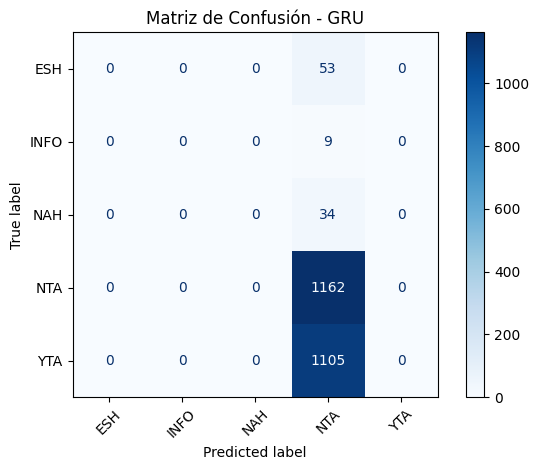

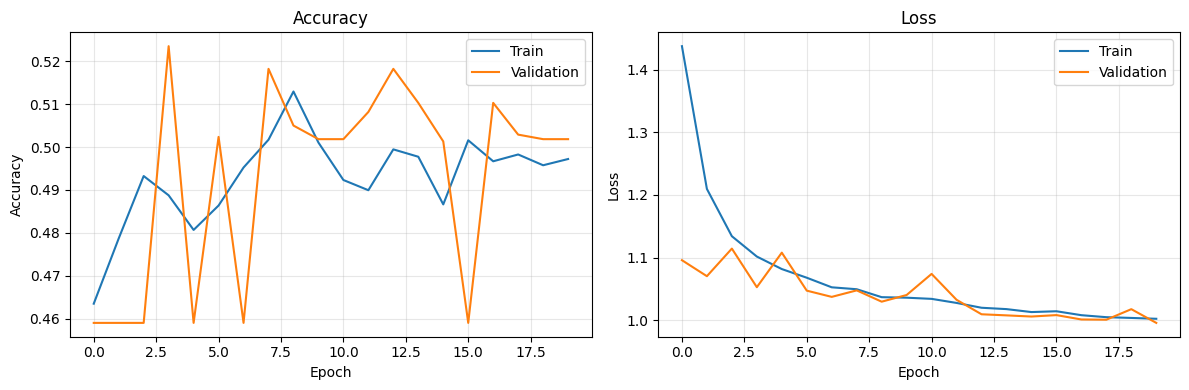

In [8]:
# Evaluación
test_loss, test_accuracy = model.evaluate(X_test_arr, y_test_enc, verbose=0)
print(f"\nResultados en test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Predicciones
y_pred_proba = model.predict(X_test_arr, verbose=0)
y_pred = y_pred_proba.argmax(axis=1)

# Métricas
precision_weighted = precision_score(y_test_enc, y_pred, average='weighted')
recall_weighted = recall_score(y_test_enc, y_pred, average='weighted')
f1_weighted = f1_score(y_test_enc, y_pred, average='weighted')

print(f"\nMétricas:")
print(f"Precision: {precision_weighted:.4f}")
print(f"Recall: {recall_weighted:.4f}")
print(f"F1-Score: {f1_weighted:.4f}")

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Matriz de Confusión - GRU")
plt.tight_layout()
plt.show()

# Gráficas de entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
